In [64]:
from math import round
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from utils import load_model
from problems import OP

# Orienteering Problem

## Generate Dataset

In [209]:
# This is the methods that is used by calling make_dataset below

# function for generating op dataset
def generate_op_data(dataset_size, op_size, prize_type='const'):
    depot = np.random.uniform(size=(dataset_size, 2))
    loc = np.random.uniform(size=(dataset_size, op_size, 2))

    # Methods taken from Fischetti et al. 1998
    if prize_type == 'const':
        prize = np.ones((dataset_size, op_size))
    elif prize_type == 'unif':
        prize = (1 + np.random.randint(0, 100, size=(dataset_size, op_size))) / 100.
    else:  # Based on distance to depot
        assert prize_type == 'dist'
        prize_ = np.linalg.norm(depot[:, None, :] - loc, axis=-1)
        prize = (1 + (prize_ / prize_.max(axis=-1, keepdims=True) * 99).astype(int)) / 100.

    # Max length is approximately half of optimal TSP tour, such that half (a bit more) of the nodes can be visited
    # which is maximally difficult as this has the largest number of possibilities
    MAX_LENGTHS = {
        20: 2.,
        50: 3.,
        100: 4.
    }

    return depot, loc, prize, np.full(dataset_size, MAX_LENGTHS[op_size])  # Capacity, same for whole dataset

In [3]:
# generate op data
depot, loc, prize, max_length = generate_op_data(10000, 20)

## Prizes with const distribution

In [187]:
n_samples = 10
size = 20
distribution = 'const' # distribution of prizes

### Load Pretrained Model

In [188]:
model, _ = load_model(f'pretrained/op_{distribution}_{size}/')
dataset = OP.make_dataset(size=size, num_samples=n_samples, distribution=distribution)

  [*] Loading model from pretrained/op_const_20/epoch-99.pt


### Visualize a scenario

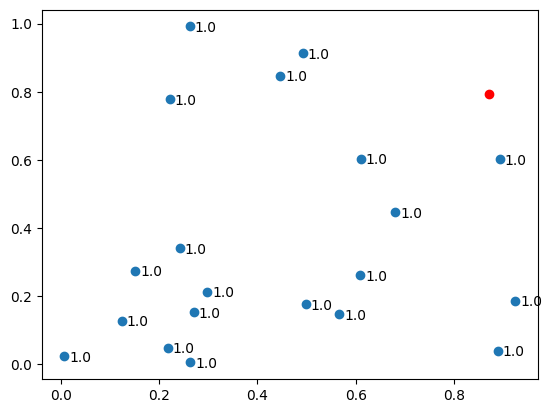

In [189]:
# pick a scenario
scenario = dataset.data[0]

# plot an op graph
plt.plot(scenario['loc'][:, 0], scenario['loc'][:, 1], 'o')

# plot the depot
plt.plot(scenario['depot'][0], scenario['depot'][1], 'o', color='red')

# Add text to the plot
for i in range(scenario['loc'].shape[0]):
    plt.text(scenario['loc'][i, 0] + 0.01, scenario['loc'][i, 1] - 0.015, round(scenario['prize'][i].item(), 2))

### Use the model to evaluate

In [206]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1000)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True)
tours = pi

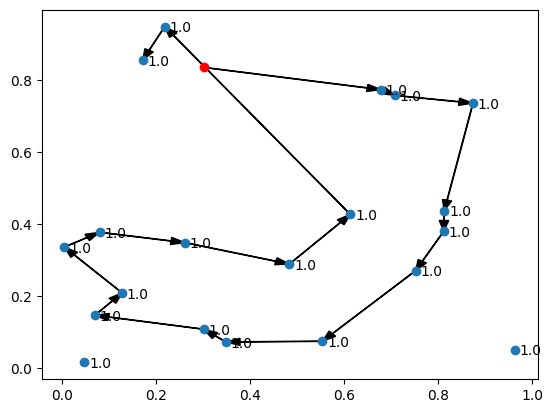

In [207]:
# pick a scenario
sel_scenario = 1
scenario = dataset.data[sel_scenario]
tour = tours[sel_scenario, :]

# plot an op graph
plt.plot(scenario['loc'][:, 0], scenario['loc'][:, 1], 'o')

# plot the depot
plt.plot(scenario['depot'][0], scenario['depot'][1], 'o', color='red')

# Add text to the plot
for i in range(scenario['loc'].shape[0]):
    plt.text(scenario['loc'][i, 0] + 0.01, scenario['loc'][i, 1] - 0.015, round(scenario['prize'][i].item(), 2))

start_x = scenario['depot'][0]
start_y = scenario['depot'][1]
for i, node in enumerate(tour):
    if node != 0:
        dx = scenario['loc'][(node - 1).item(), 0] - start_x
        dy = scenario['loc'][(node - 1).item(), 1] - start_y
        
        plt.arrow(start_x, start_y, dx, dy,  length_includes_head=True, head_width=0.02,  facecolor='black')

        start_x = scenario['loc'][(node - 1).item(), 0]
        start_y = scenario['loc'][(node - 1).item(), 1]
    

## Prizes with uniform distribution

In [212]:
n_samples = 10
size = 20
distribution = 'unif' # distribution of prizes

### Load Pretrained Model

In [213]:
model, _ = load_model(f'pretrained/op_{distribution}_{size}/')
dataset = OP.make_dataset(size=size, num_samples=n_samples, distribution=distribution)

  [*] Loading model from pretrained/op_unif_20/epoch-99.pt


### Visualize a scenario

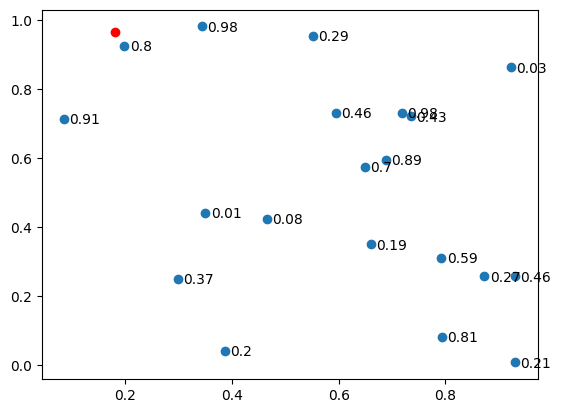

In [214]:
# pick a scenario
scenario = dataset.data[0]

# plot an op graph
plt.plot(scenario['loc'][:, 0], scenario['loc'][:, 1], 'o')

# plot the depot
plt.plot(scenario['depot'][0], scenario['depot'][1], 'o', color='red')

# Add text to the plot
for i in range(scenario['loc'].shape[0]):
    plt.text(scenario['loc'][i, 0] + 0.01, scenario['loc'][i, 1] - 0.015, round(scenario['prize'][i].item(), 2))

### Use the model to evaluate

In [253]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1000)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True)
tours = pi

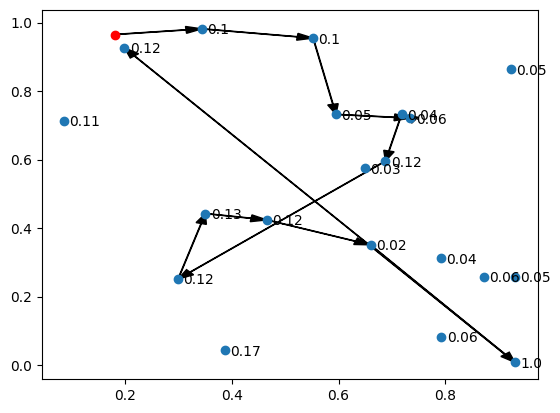

In [254]:
# pick a scenario
sel_scenario = 0
scenario = dataset.data[sel_scenario]
tour = tours[sel_scenario, :]

# plot an op graph
plt.plot(scenario['loc'][:, 0], scenario['loc'][:, 1], 'o')

# plot the depot
plt.plot(scenario['depot'][0], scenario['depot'][1], 'o', color='red')

# Add text to the plot
for i in range(scenario['loc'].shape[0]):
    plt.text(scenario['loc'][i, 0] + 0.01, scenario['loc'][i, 1] - 0.015, round(scenario['prize'][i].item(), 2))

start_x = scenario['depot'][0]
start_y = scenario['depot'][1]
for i, node in enumerate(tour):
    if node != 0:
        dx = scenario['loc'][(node - 1).item(), 0] - start_x
        dy = scenario['loc'][(node - 1).item(), 1] - start_y
        
        plt.arrow(start_x, start_y, dx, dy,  length_includes_head=True, head_width=0.02,  facecolor='black')

        start_x = scenario['loc'][(node - 1).item(), 0]
        start_y = scenario['loc'][(node - 1).item(), 1]
    

In [241]:
dataset.data[0]['prize'][7] = torch.tensor(1.0)

In [237]:
dataset.data[0]['prize'] = torch.rand(20) * 0.2

In [233]:
torch.rand(10) * 0.2

tensor([0.1791, 0.1845, 0.1967, 0.0606, 0.0029, 0.0509, 0.1418, 0.1524, 0.0090,
        0.1554])

In [251]:
dataset.data[0]['max_length']

tensor(4.)

In [250]:
dataset.data[0]['max_length'] = torch.tensor(4.0)